# Imports

In [1]:
import polars as pl
import librosa
import numpy as np
import pickle
import matplotlib.pyplot as plt
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import polars as pl
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset & Preliminary Exploration

In [2]:
with open('processed_data.pkl', 'rb') as f:  # 'rb' = read binary
    df = pickle.load(f)

In [3]:
print(f"Information about processed dataframe:\nShape: {df.shape}\nFeatures: {df.columns}")
print(f"There are {len(df['Label'].unique())} labels.")
print(f"Labels: {list(df['Label'].unique())}")

Information about processed dataframe:
Shape: (7077, 7)
Features: ['Filename', 'Audio', 'ID', 'Label', 'Duration', 'Index', 'Spectrogram']
There are 22 labels.
Labels: ['hunger', 'frustrated', 'tablet', 'greeting', 'yes', 'dysregulation-bathroom', 'bathroom', 'laugh', 'dysregulated', 'protest', 'glee', 'dysregulation-sick', 'help', 'delighted', 'no', 'affectionate', 'request', 'more', 'selftalk', 'social', 'happy', 'laughter']


# Exploratory Data Analysis

### Notes
- The Mel Spectrograms are represented as List[List[f32]] with mel_spec[time_frame][mel_bin]
    - Each row (mel_spec[i]) is a snapshot of the frequency distribution at a specific time window.
        - Example: mel_spec[0] = frequencies at time = 0, mel_spec[1] = frequencies at the next time step, etc.
    - Each column (mel_spec[:][j]) is the amplitude/power of a specific Mel band across time.
        - Example: mel_spec[:][0] = energy in the lowest-frequency Mel band over time.
- Each value mel_spec[i][j] is a float32 representing the energy/power in the j-th Mel band at the i-th time frame.
    - Higher values = stronger presence of that frequency band at that time.
    - Lower/negative values = weaker or no energy (often clipped to 0 or log-scaled).

### Class Imbalance

{'happy': 61, 'selftalk': 1885, 'request': 419, 'more': 22, 'no': 12, 'laugh': 8, 'glee': 8, 'greeting': 3, 'dysregulation-bathroom': 18, 'dysregulation-sick': 74, 'delighted': 1272, 'frustrated': 1536, 'social': 634, 'yes': 123, 'help': 24, 'protest': 21, 'affectionate': 129, 'dysregulated': 704, 'laughter': 93, 'tablet': 7, 'bathroom': 20, 'hunger': 4}


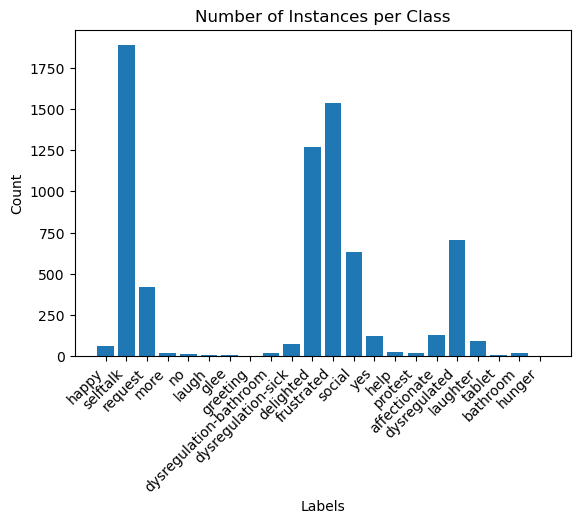

In [4]:
m = df.select(pl.col("Label").value_counts())['Label'].to_list()
label_counts = {e['Label'] : e['count'] for e in m}
print(label_counts)
# Convert dictionary to DataFrame
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Create bar plot (histogram-like)
plt.bar(labels, counts)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Number of Instances per Class")
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')  # 'ha' is horizontal alignment

# Add some padding at the bottom for the labels
plt.subplots_adjust(bottom=0.2)
plt.show()

### Visualization

In [5]:
# plots a specific spectrogram using librosa's built-in mel spectrogram conversion and display functions
def plot_spectrogram(mel_spec: list[list[float]], label: str):
    # Convert to NumPy array
    mel_spec_array = np.array(mel_spec, dtype=np.float32)

    # Create a figure
    plt.figure(figsize=(10, 4))

    # Display the Mel spectrogram in dB (log scaling)
    log_mel_spec = librosa.power_to_db(mel_spec_array, ref=np.max)  # Convert to dB
    img = librosa.display.specshow(
        log_mel_spec,
        sr=22050,                  # Sample rate (adjust if needed)
        hop_length=512,             # Hop length (adjust if needed)
        x_axis='time',             # Show time on x-axis
        y_axis='mel',              # Show mel scale on y-axis
        cmap='viridis'             # Color map (e.g., 'magma', 'viridis', 'inferno')
    )

    # Add a colorbar
    plt.colorbar(format='%+2.0f dB')

    # Add title and labels
    plt.title(f'Mel Spectrogram (128x128) for Label: {label}')
    plt.tight_layout()  # Prevent label clipping
    plt.show()

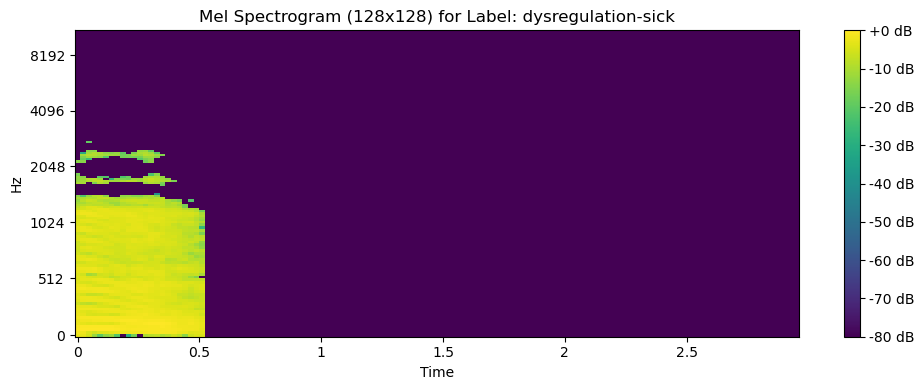

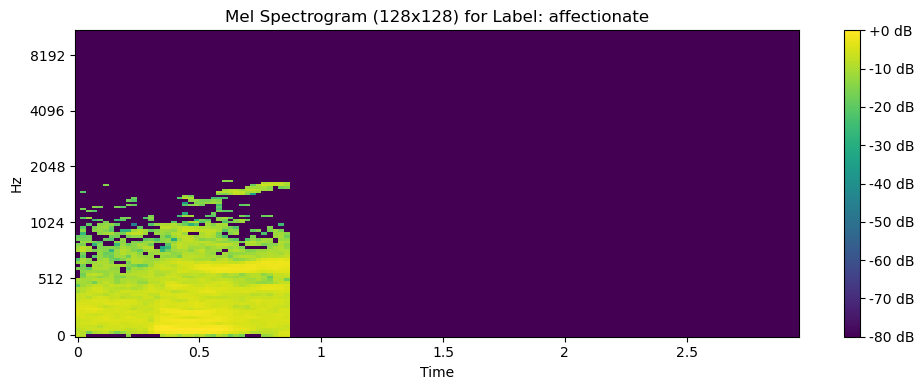

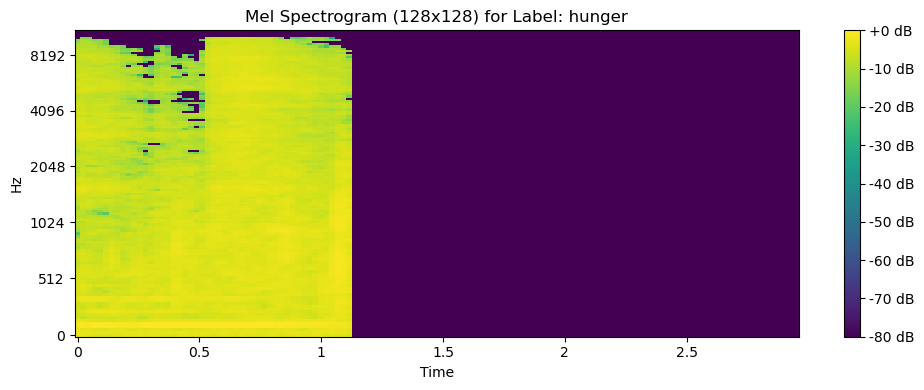

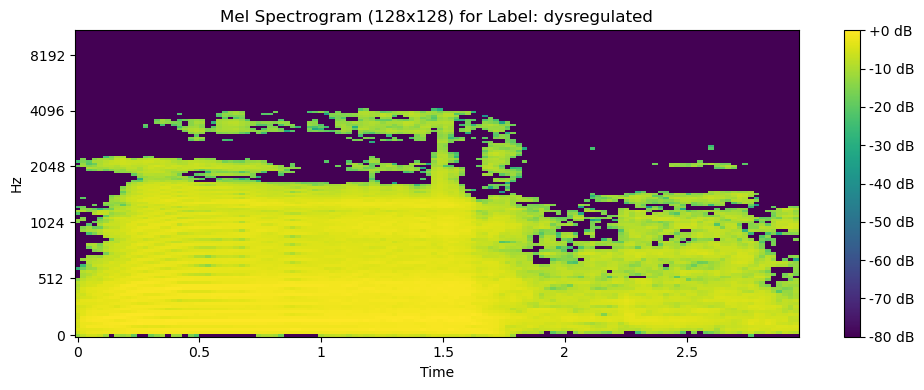

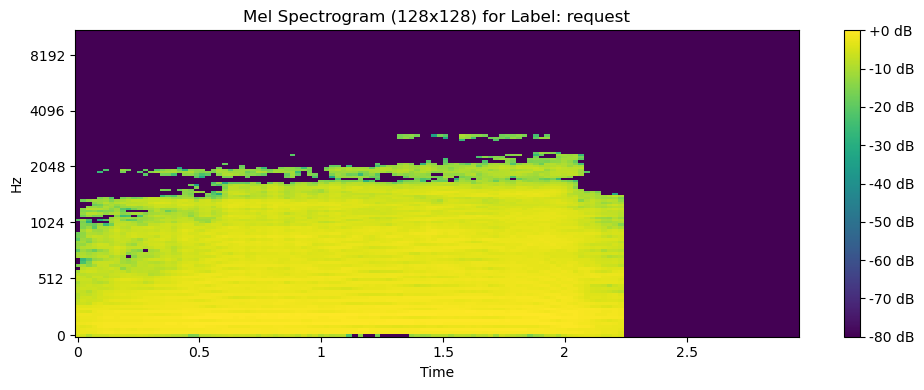

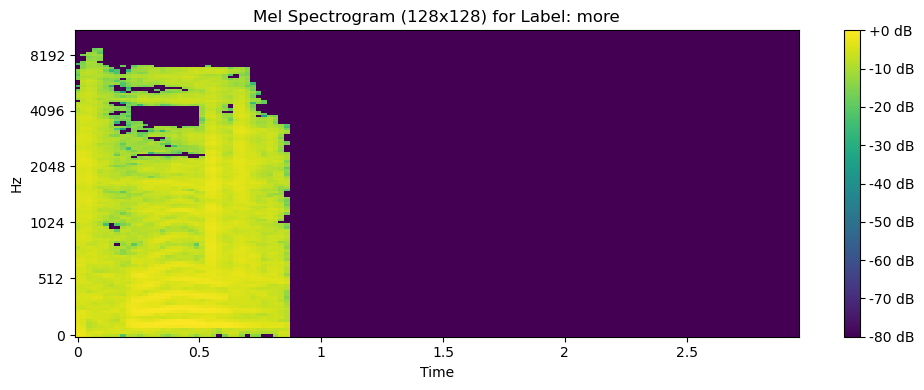

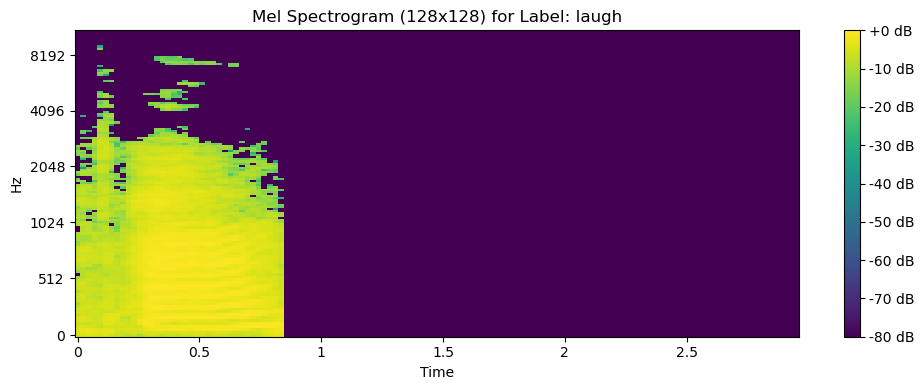

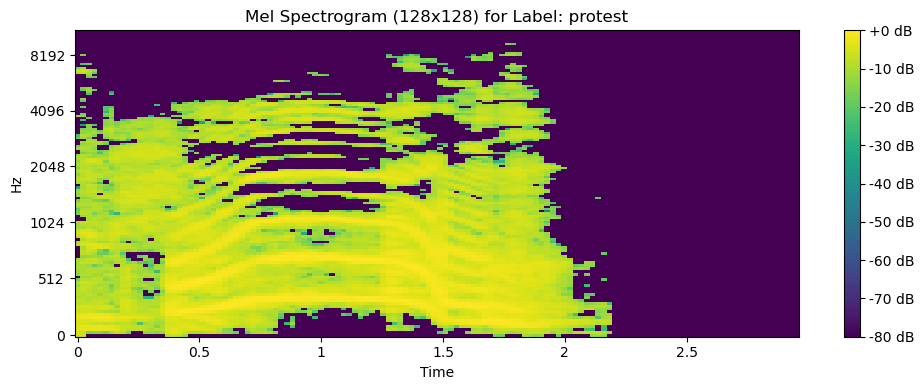

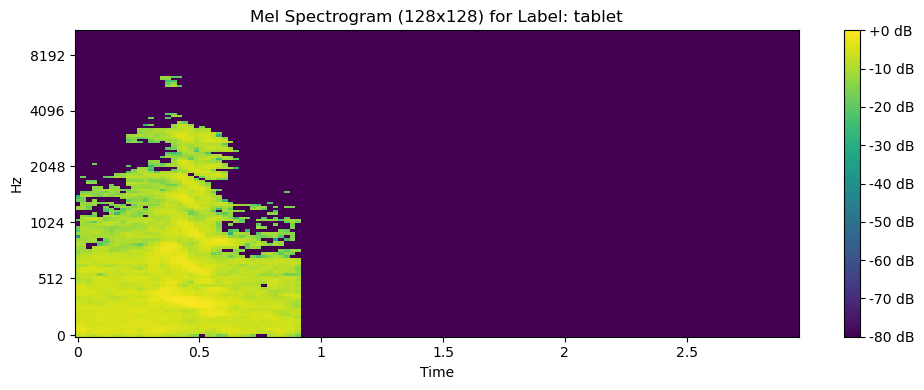

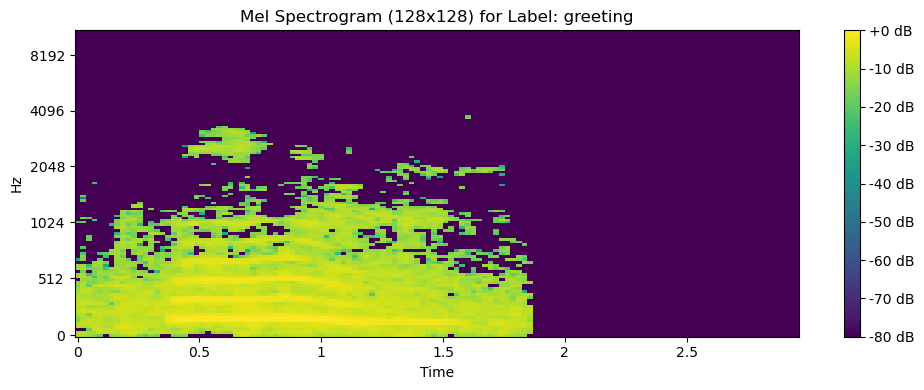

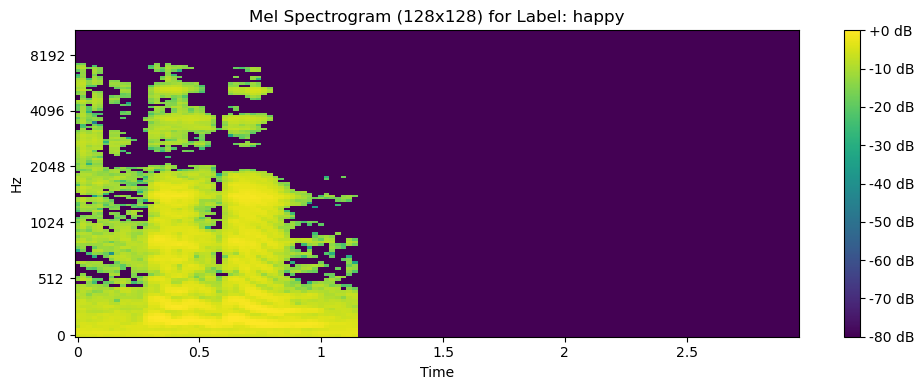

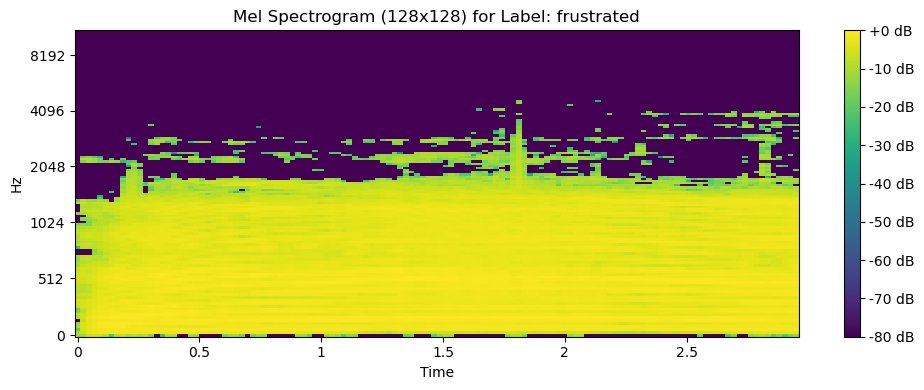

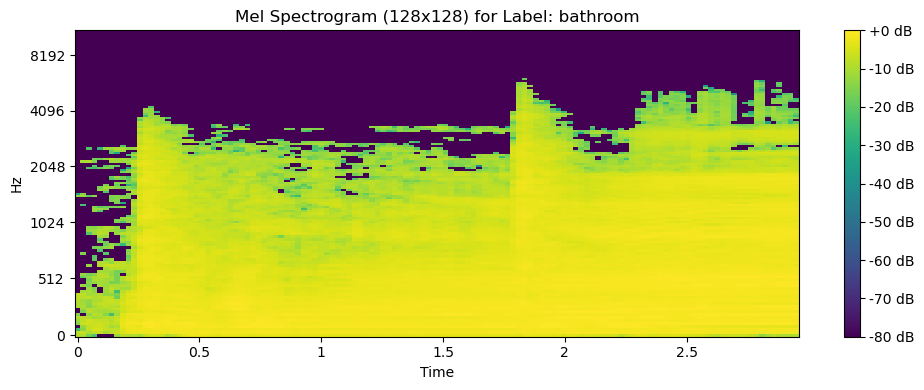

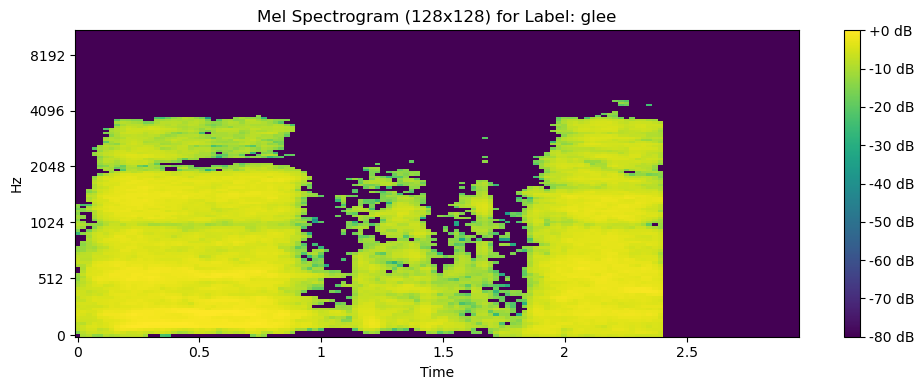

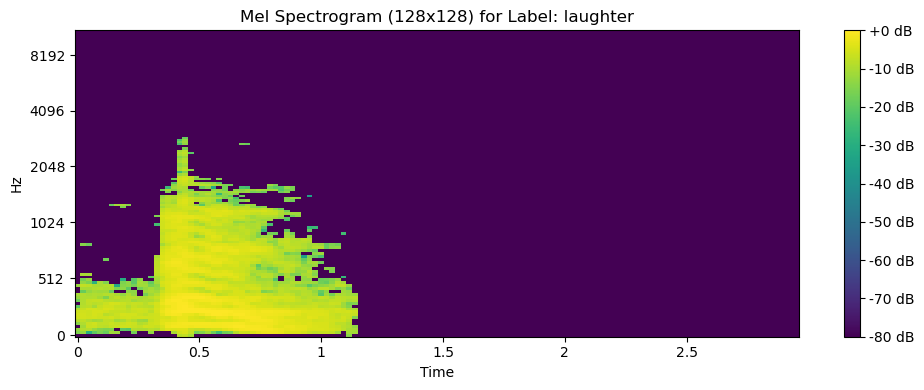

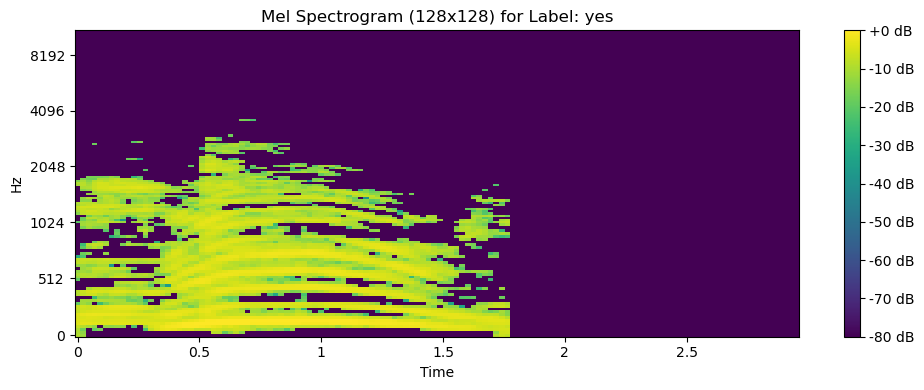

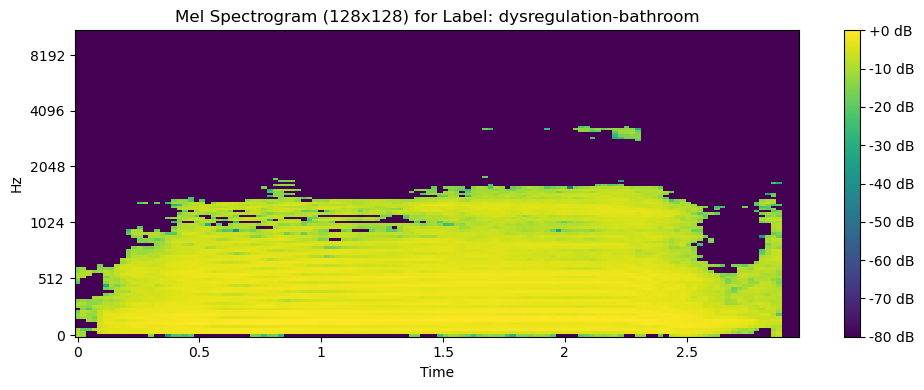

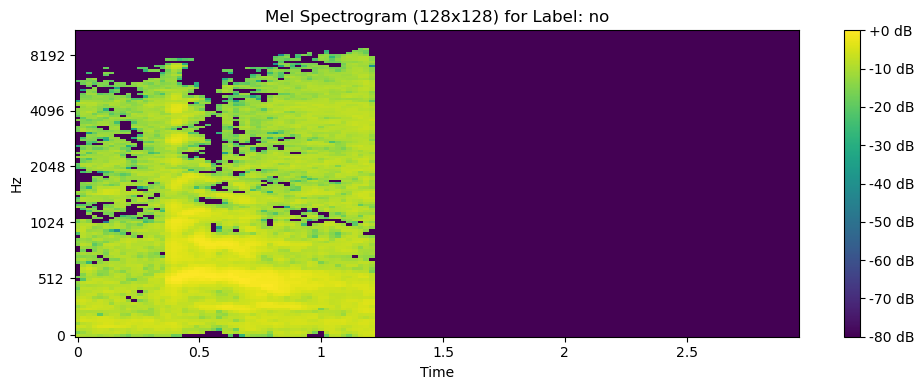

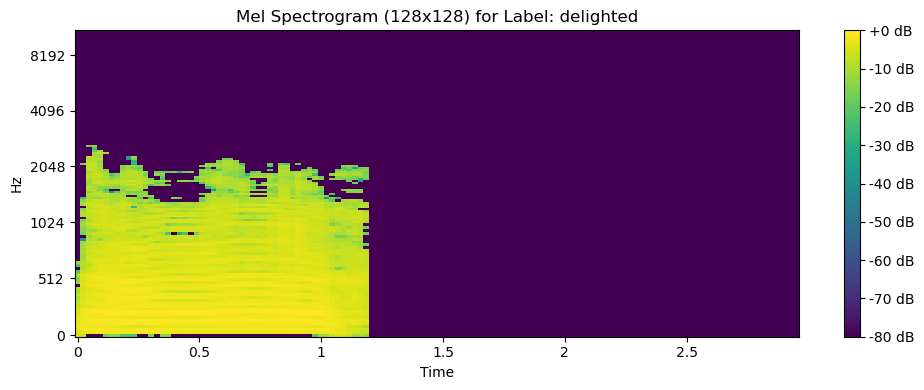

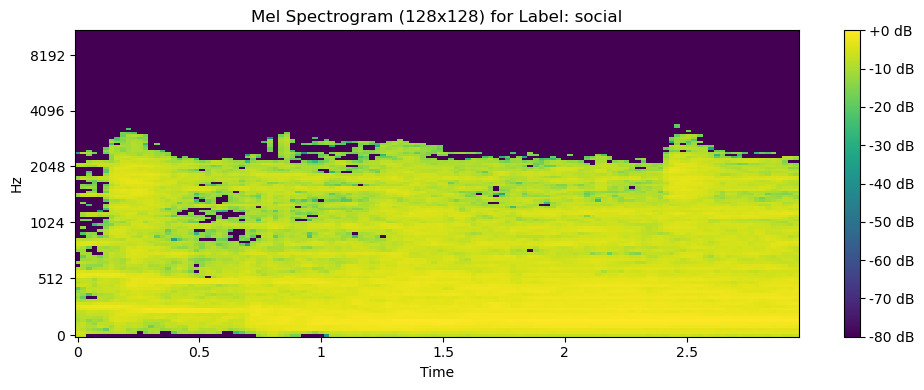

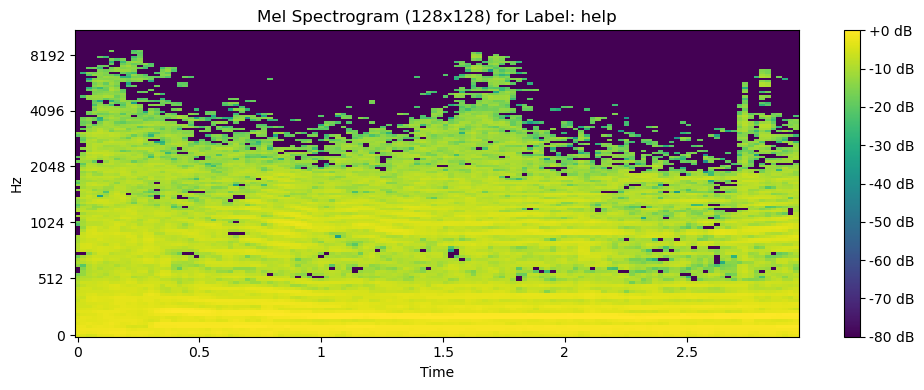

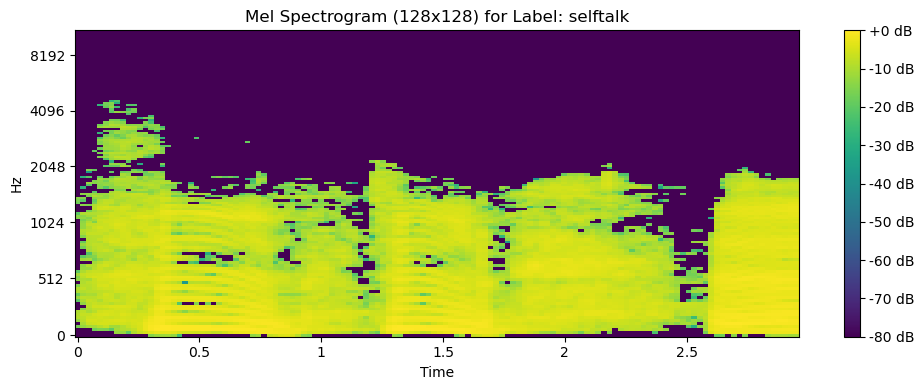

In [105]:
# plot a spectrogram for each class
for label in df['Label'].unique():
    plot_spectrogram(df.filter(pl.col('Label') == label).row(0, named=True)['Spectrogram'], label)

In [106]:
from random import randint

# plots a random spectrogram from a given label
def plot_random_spectrogram(df, label):
    subset = df.filter(pl.col('Label') == label)
    i = randint(0, len(subset) - 1)
    plot_spectrogram(subset.row(i, named=True)['Spectrogram'], label)

In [107]:
from matplotlib import colors

# plots the raw List[List[f32]] spectrogram that is fed into the model
def plot_raw_spectrogram(mel_spec: list[list[float]], label: str):
    # Convert to numpy array for easier handling
    data_array = np.array(mel_spec)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create a color scale plot (heatmap)
    heatmap = ax.imshow(data_array, cmap='viridis')  # You can change 'viridis' to other colormaps like 'plasma', 'magma', etc.

    # Add a colorbar
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label('Value Scale')

    # Add titles and labels
    ax.set_title('Raw Input for CNN')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    # Optionally add grid lines
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1)

    # Show the plot
    plt.tight_layout()
    plt.show()

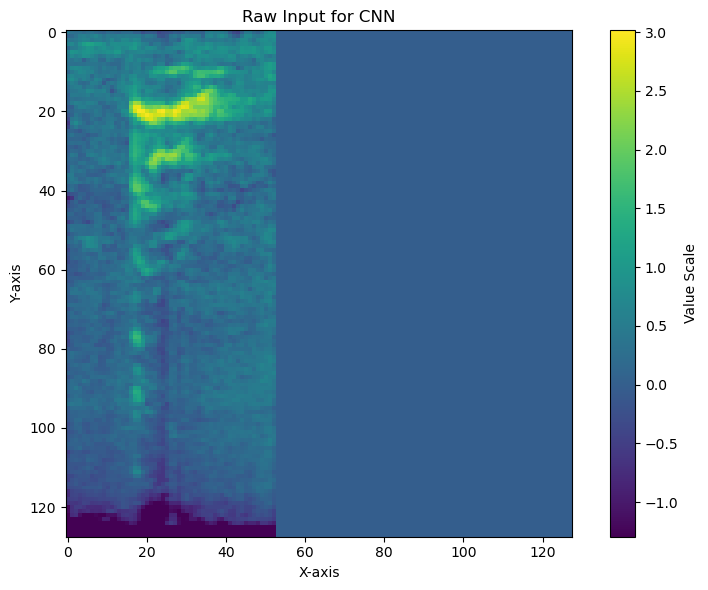

In [108]:
plot_raw_spectrogram(df.filter(pl.col('Label') == 'no').row(0, named=True)['Spectrogram'], 'no')

# Data Augmentation

We compute the average length of the Mel spectrograms (found to be 50) and truncate all spectrograms to be 128x50 to prevent the large number of zero entries in many instances from interfering with training.

In [6]:
def find_first_all_zero_columns(matrix):
    # Convert to numpy array if not already
    arr = np.array(matrix, dtype=np.float32)
    zero_cols = np.all(arr == 0, axis=0)
    for c in range(len(zero_cols)):
        if np.all(zero_cols[c:]):
            return int(c)  # Explicitly convert to Python int
    return -1  # Return -1 if no trailing zeros

In [28]:
def find_mean_len(df):
    mean_len = 0
    for mel_spec in df['Spectrogram']:
        mel_spec = mel_spec.to_list()
        mean_len += find_first_all_zero_columns(mel_spec)
    mean_len = mean_len // len(df['Spectrogram'])
    print(f"The mean length of the mel spectrograms is: {mean_len}")
    return mean_len

def truncate_spectrograms(df, valid):
    filtered_df = df.filter(pl.col("Label").is_in(valid))
    mean_len = find_mean_len(filtered_df)
    filtered_df = filtered_df.with_columns(
        truncated_spectrograms = pl.col("Spectrogram").map_elements(lambda x: [row[:mean_len] for row in x])
    )
    return filtered_df


In [29]:
valid = ['frustrated', 'delighted', 'selftalk']
filtered_df = truncate_spectrograms(df, set(valid))

The mean length of the mel spectrograms is: 48


C:\Users\ericy\AppData\Local\Temp\ipykernel_21768\2818775043.py:13: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  filtered_df = filtered_df.with_columns(


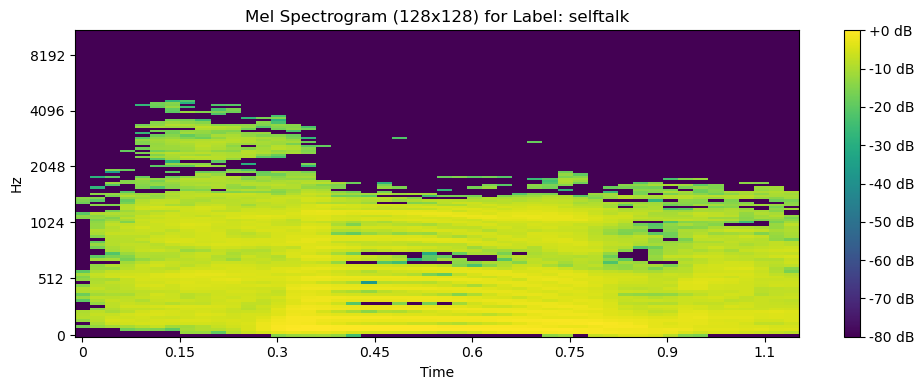

In [36]:
plot_spectrogram(filtered_df.filter(pl.col('Label') == 'selftalk').row(0, named=True)['truncated_spectrograms'], 'selftalk')

# Create and Train CNN

In [31]:
# 1. Define Dataset Class
class SpectrogramDataset(Dataset):
    def __init__(self, df):
        self.spectrograms = df["truncated_spectrograms"].to_list()
        self.labels = df["Label"].to_list()
        
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)
        
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        spectrogram = np.array(self.spectrograms[idx], dtype=np.float32)
        spectrogram = np.expand_dims(spectrogram, axis=0)
        label = self.encoded_labels[idx]
        return torch.from_numpy(spectrogram), torch.tensor(label, dtype=torch.long)

In [32]:
# 2. Define CNN Model
class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes=len(valid)):
        super(SpectrogramCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 16 * 6, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [33]:
# 3. Training Setup
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss += criterion(outputs, labels).item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return loss / len(data_loader.dataset), correct / total

def train_model(df, num_epochs=100, batch_size=32, learning_rate=0.001):
    # Split data into train (60%), validation (20%), and test (20%)
    train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    # Create datasets
    train_dataset = SpectrogramDataset(train_df)
    val_dataset = SpectrogramDataset(val_df)
    test_dataset = SpectrogramDataset(test_df)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = SpectrogramCNN(num_classes=len(valid))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    class_counts = torch.tensor([label_counts[label] for label in valid])
    class_weights = 1. / class_counts.float()
    class_weights = class_weights / class_weights.sum()

    # Modify your criterion
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f} - "
              f"Val Loss: {val_loss:.4f} - "
              f"Val Acc: {val_acc:.4f}")
    
    return model, train_dataset.label_encoder, test_loader

In [34]:
# 4. Evaluation functions
def generate_classification_report(model, data_loader, label_encoder, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert numerical labels back to original strings
    pred_classes = label_encoder.inverse_transform(all_preds)
    true_classes = label_encoder.inverse_transform(all_labels)
    
    print("Classification Report:")
    print(classification_report(true_classes, pred_classes, target_names=label_encoder.classes_))
    
    return true_classes, pred_classes

def plot_confusion_matrix(true_classes, pred_classes, label_encoder):
    cm = confusion_matrix(true_classes, pred_classes, labels=label_encoder.classes_)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Epoch 1/100 - Train Loss: 1.8614 - Val Loss: 0.9085 - Val Acc: 0.5591
Epoch 2/100 - Train Loss: 0.9230 - Val Loss: 0.8448 - Val Acc: 0.5847
Epoch 3/100 - Train Loss: 0.8773 - Val Loss: 0.8152 - Val Acc: 0.5964
Epoch 4/100 - Train Loss: 0.8673 - Val Loss: 0.8120 - Val Acc: 0.5932
Epoch 5/100 - Train Loss: 0.8454 - Val Loss: 0.7936 - Val Acc: 0.6400
Epoch 6/100 - Train Loss: 0.8247 - Val Loss: 0.7694 - Val Acc: 0.6422
Epoch 7/100 - Train Loss: 0.8163 - Val Loss: 0.7993 - Val Acc: 0.5815
Epoch 8/100 - Train Loss: 0.8225 - Val Loss: 0.7657 - Val Acc: 0.6528
Epoch 9/100 - Train Loss: 0.7818 - Val Loss: 0.7831 - Val Acc: 0.6560
Epoch 10/100 - Train Loss: 0.7791 - Val Loss: 0.7600 - Val Acc: 0.6486
Epoch 11/100 - Train Loss: 0.7530 - Val Loss: 0.7361 - Val Acc: 0.6677
Epoch 12/100 - Train Loss: 0.7348 - Val Loss: 0.7381 - Val Acc: 0.6550
Epoch 13/100 - Train Loss: 0.7314 - Val Loss: 0.7207 - Val Acc: 0.6901
Epoch 14/100 - Train Loss: 0.6796 - Val Loss: 0.7403 - Val Acc: 0.6741
Epoch 15/100 - 

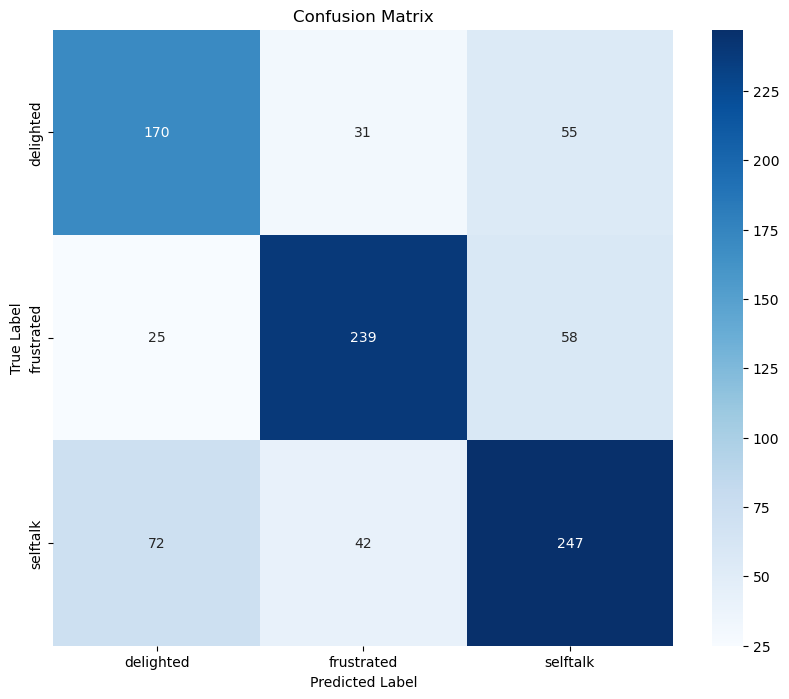

In [35]:
# 5. Main execution
if __name__ == "__main__":
    # Train the model and get test loader
    model, label_encoder, test_loader = train_model(df)
    
    # Evaluate on test set
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loss, test_acc = evaluate_model(model, test_loader, nn.CrossEntropyLoss(), device)
    print(f"\nTest Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}")
    
    # Generate and display classification metrics
    true_classes, pred_classes = generate_classification_report(
        model, test_loader, label_encoder, device
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(true_classes, pred_classes, label_encoder)
    
    # Save the model and label encoder
    torch.save(model.state_dict(), "spectrogram_cnn.pth")
    np.save("label_encoder.npy", label_encoder.classes_)